## 3. 볼린저 밴드 계산과 매수/매도 전략 테스트

볼린저 밴드: 시간에 따른 특정 자산 가격과 변동성의 정보를 도출하는데 사용되는 통계적 방법

- 볼린저 밴드 상한선 : 20일 이동평균선 값 + (20일 동안의 주가 표준편차 값) $\times$ K <br>
볼린저 밴드 하한선 : 20일 이동평균선 값 - (20일 동안의 주가 표준편차 값) $\times$ K <br>
(보통 K는 2로 설정함)

- 변동성이 증가하면 밴드가 넓어지고, 변동성이 감소하면 밴드가 축소한다.

거래 전략을 아래와 같이 설정하여 테스트해보겠다.
1. 주식 가격이 볼린저 밴드 하한선을 상향으로 교차할 때 매수
2. 주식 가격이 볼린저 밴드 상한선을 하향 교차할 때 매도
3. 올인 전략-매수 전략을 수립할 때  최대한 많은 주식을 매수
4. 공매도는 허용되지 않음

In [39]:
import pandas as pd
import yfinance as yf
import backtrader as bt
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
class Bollinger(bt.Strategy):
    params = (('period',20), ('devfactor', 2.0),)
    
    def __init__(self):
        self.data_close = self.datas[0].close #종가 추적
        self.data_open = self.datas[0].open #시가
        
        self.order = None
        self.price = None
        self.commission = None
        
        # 볼린저 밴드 추가, 매수/매도 신호 추적
        self.b_band = bt.ind.BollingerBands(self.datas[0],period=self.p.period,devfactor=self.p.devfactor)
        self.buy_signal = bt.ind.CrossOver(self.datas[0],self.b_band.lines.bot)
        self.sell_signal = bt.ind.CrossOver(self.datas[0],self.b_band.lines.top)
        
    def log(self,txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt},{txt}')
        
    def notify_order(self,order):
        if order.status in [order.Submitted, order.Accepted]:
            return
            
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                    
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Failed')
            
        self.order = None
            
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
        
    def next_open(self):
        if not self.position: # 한번에 한 포지션만 가능?
            if self.buy_signal > 0:
                size = int(self.broker.getcash()/self.datas[0].open) # 현금 보유 한 것만큼 최대한 매수
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
                    
        else:
            if self.sell_signal < 0:
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

In [25]:
yf.download('BTC-USD','2020-01-01','2020-1-10')

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-31,7294.438965,7335.290039,7169.777832,7193.599121,7193.599121,21167946112
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095
2020-01-06,7410.452148,7781.867188,7409.292969,7769.219238,7769.219238,23276261598
2020-01-07,7768.682129,8178.215820,7768.227539,8163.692383,8163.692383,28767291327
2020-01-08,8161.935547,8396.738281,7956.774414,8079.862793,8079.862793,31672559265


In [31]:
bitcoin = bt.feeds.PandasData(dataname=yf.download('BTC-USD','2019-01-01','2020-12-31'))
bitcoin

[*********************100%***********************]  1 of 1 completed


In [57]:
#t일의 종가를 추적해 신호를 계산하고, t+1일의 시가를 기준으로 주식 매수

bollinger = bt.Cerebro(stdstats = False, cheat_on_open=True) 

bollinger.addstrategy(Bollinger)
bollinger.adddata(bitcoin)
bollinger.broker.setcash(1000000.0)
bollinger.broker.setcommission(commission=0.002)
bollinger.addobserver(bt.observers.BuySell)
bollinger.addobserver(bt.observers.Value)
bollinger.addanalyzer(bt.analyzers.Returns, _name='returns')
bollinger.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')

In [58]:
print('Starting Portfolio Value: %.2f' % bollinger.broker.getvalue())
backtest_result = bollinger.run()
print('Final Portfolio Value: %.2f' % bollinger.broker.getvalue())

Starting Portfolio Value: 1000000.00
2019-01-31,BUY CREATED --- Size: 286, Cash: 1000000.00, Open: 3485.4091796875, Close: 3457.792724609375
2019-01-31,BUY EXECUTED --- Price: 3485.41, Cost: 996827.03, Commission: 1993.65
2019-02-22,SELL CREATED --- Size: 286
2019-02-22,SELL EXECUTED --- Price: 3952.41, Cost: 996827.03, Commission: 2260.78
2019-02-22,OPERATION RESULT --- Gross: 133561.23, Net: 129306.80
2019-07-18,BUY CREATED --- Size: 116, Cash: 1129306.80, Open: 9698.5029296875, Close: 10666.482421875
2019-07-18,BUY EXECUTED --- Price: 9698.50, Cost: 1125026.34, Commission: 2250.05
2019-08-07,SELL CREATED --- Size: 116
2019-08-07,SELL EXECUTED --- Price: 11476.19, Cost: 1125026.34, Commission: 2662.48
2019-08-07,OPERATION RESULT --- Gross: 206212.09, Net: 201299.56
2019-09-23,BUY CREATED --- Size: 132, Cash: 1330606.36, Open: 10067.962890625, Close: 9729.32421875
2019-09-23,Order Failed
2019-09-29,BUY CREATED --- Size: 161, Cash: 1330606.36, Open: 8246.037109375, Close: 8104.18554687

<IPython.core.display.Javascript object>


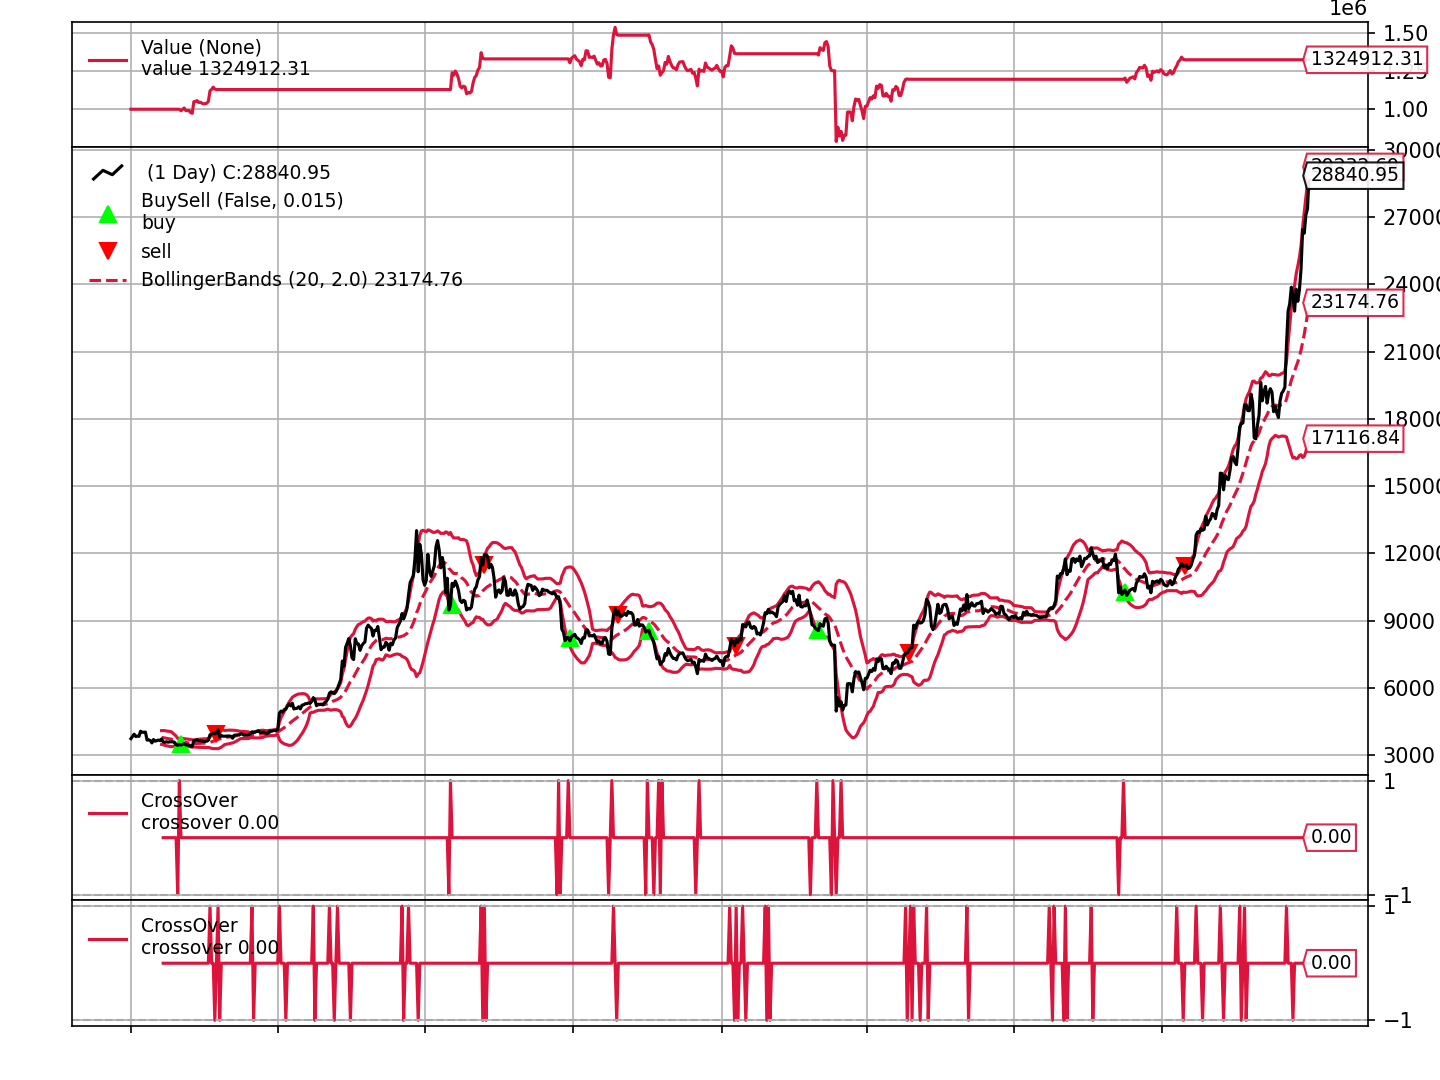

[[<Figure size 640x480 with 4 Axes>]]

In [59]:
bollinger.plot(iplot=True, volume=False)

- 위의 전략이 $\$3224912.31$ 의 이익을 가져왔음을 알 수 있다. iplot을 통해 전략이 제대로 수행되고 있었음을 시각적으로 볼 수 있다.

### 일별 포트폴리오 수익률

In [60]:
print(backtest_result[0].analyzers.returns.get_analysis())

OrderedDict([('rtot', 0.28134627376550353), ('ravg', 0.000384878623482221), ('rnorm', 0.10184870841647455), ('rnorm100', 10.184870841647454)])


<IPython.core.display.Javascript object>


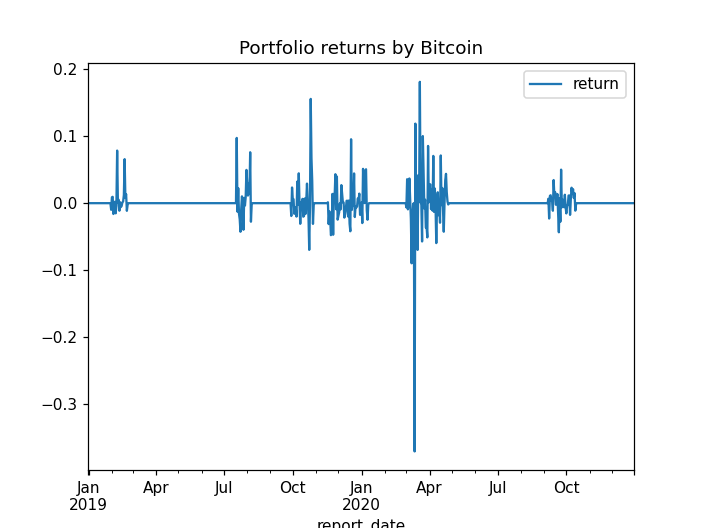

In [61]:
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
returns_df = pd.DataFrame(list(returns_dict.items()), columns = ['report_date', 'return']).set_index('report_date')
returns_df.plot(title='Portfolio returns by Bitcoin')
plt.show()

## 4. 상대 강도 지수(RSI) 계산 및 롱/숏 전략 테스트

RSI(Relative Strength Index) : 자산의 종가를 이용해 매수/매도 조건을 식별하는 지표
- U : n일 동안의 종가 상승 분 <br>
D : n일 동안의 종가 하락 분 <br>
AU : U의 평균 <br>
AD: : D 평균
- RSI = AU/(AU+AD) $\times$ 100 <br> (보통 n은 14를 사용한다.)

RSI는 0~100 규모로 측정되며 30미만인 경우 초과매도 국면, 70 이상인 경우 초과매수 국면으로 규정하였다. 따라서 RSI가 30미만이면 매수 포지션, 70이상이면 매도 포지션을 취하는 것이 일반적이다. 초과매수, 초과매도 국면에서 가격이 쉽게 반전되지 않고 추세가 연장되는 경우가 많기 때문에 RSI가 70을 넘어선 이후 다시 70 밑으로 내려오는 것을 확인하고 매도하고, RSI가 30 이하로 내려갔다가 다시 30 이상으로 올라오면 그 때 매수하는 방법을 이용한다.

거래 전략
1. 롱이나 숏 포지션을 취할 수 있다.
2. RSI 계산을 위해서 14일 기간을 이용한다.
3. RSI가 하한 임계치(30)를 위쪽으로 교차하면 롱 포지션 입력. RSI가 중간 레벨(50)보다 가지면 포지션을 엑시트 한다.
4. RSI가 상한 임계치(70)을 아래쪽으로 교차하면 숏 포지션을 입력한다. RSI가 50보다 작아지면 포지션을 엑시트한다.
5. 한 번에 하나의 포지션만 오픈할 수 있다.

In [71]:
class rsi_strategy(bt.SignalStrategy):
    params = dict(rsi_periods=14, rsi_upper=70, rsi_lower=30, rsi_mid=50)

    def __init__(self):

        # rsi 지표 추가
        rsi = bt.indicators.RSI(period=self. p.rsi_periods,upperband=self. p.rsi_upper,lowerband=self.p.rsi_lower)

        # 롱 포지션 조건 
        rsi_signal_long = bt.ind.CrossUp(rsi, self.p.rsi_lower, plot=False) #조건 만족 시1반환 
        self.signal_add(bt.SIGNAL_LONG, rsi_signal_long)
        self.signal_add(bt.SIGNAL_LONGEXIT, -(rsi > self.p.rsi_mid)) # 50 초과하면 롱 포지션 exit, 롱 포지션 엑시트 위해선 값이 음수

        # 숏 포지션 조건
        rsi_signal_short = -bt.ind.CrossDown(rsi, self.p.rsi_upper, plot=False) #조건 만족 시 1반환 후 음수로 변환 -> 숏 신호
        self.signal_add(bt.SIGNAL_SHORT, rsi_signal_short)
        self.signal_add(bt.SIGNAL_SHORTEXIT, rsi < self.p.rsi_mid) #50 미만이면 숏 포지션 exit

In [72]:
TSLA = bt.feeds.PandasData(dataname=yf.download('TSLA','2020-01-01','2020-12-31'))
TSLA

[*********************100%***********************]  1 of 1 completed


In [73]:
rsi_tsla = bt.Cerebro(stdstats = False)

# # set up the backtest
rsi_tsla.addstrategy(rsi_strategy)
rsi_tsla.adddata(TSLA)
rsi_tsla.broker.setcash(10000.0)
rsi_tsla.broker.setcommission(commission=0.005)
rsi_tsla.addobserver(bt.observers.BuySell)
rsi_tsla.addobserver(bt.observers.Value)
rsi_tsla.run()

<IPython.core.display.Javascript object>


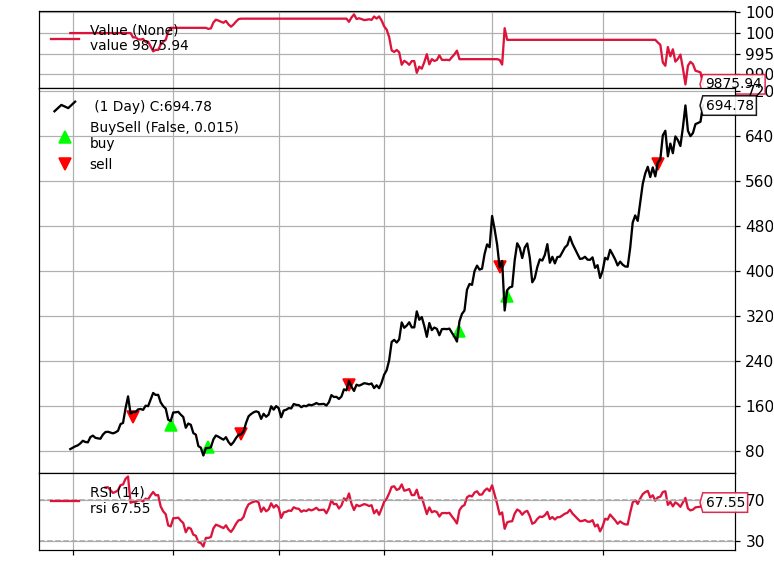

[[<Figure size 640x480 with 3 Axes>]]

In [74]:
rsi_tsla.plot(iplot=True, volume=False)

- 아래의 빨간색 선 그래프에서 RSI 전략을 시각화한 것을 볼 수 있고, 그에 따라 위의 주식의 매수/매도 전략이 시행됨을 시각화를 통해 알 수 있다.